# @3
# GHI CHÚ
# I) File này dùng để tính toán các chỉ số RFM của khách hàng và tiến hành phân cụm. Sau đó đưa vào bảng Phan_khuc_KH trong CSDL Ban_HANG
# II) Sử dụng dữ liệu từ bảng SO_CHI_TIET trong CSDL Ban_Hang

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter
import numpy as np
import pyodbc

# B1 tính RFM

In [3]:
def cal_RFM():
    pd.options.display.float_format = '{:.2f}'.format
    #Lay ra SO_CHI_TIET
    query = "SELECT * FROM SO_CHI_TIET where Ma_KH not in ('Sampling','Tu_thien')"
    df = pd.read_sql_query(query, conn)
    #Giả sử ngày hiện tại là ngày phát sinh giao dịch cuối cùng + 1 trong SO_CHI_TIET
    current_date = max(df['Ngay_chung_tu']) + datetime.timedelta(days=1)
    #Tính RFM
    df_customers = df.groupby(['Ma_KH']).agg(
    {'Ngay_chung_tu': lambda x: (current_date- x.max()).days,
     'So_hoa_don':'nunique',
     'Doanh_so':'sum'
     }
    )
    df_customers.rename(columns={'Ngay_chung_tu':'Recency','So_hoa_don':'Frequency','Doanh_so':'MonetaryValue'}, inplace=True)
    return df_customers
    

In [4]:
df_customers = cal_RFM()

In [5]:
df_customers

,Recency,Frequency,MonetaryValue
Ma_KH,,,
KH00001,1095,1,164320000.00
KH00002,858,2,96175000.00
KH00003,10,31,4363511324.00
KH00004,7,35,3945543723.00
KH00005,6,35,6895584252.00
...,...,...,...
KH00329,1,1,13204854.00
KH00330,1,1,10303904.00
KH00331,1,1,14016860.00


# B2: Vẽ phân phối để lựa chọn phương pháp Transform

D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

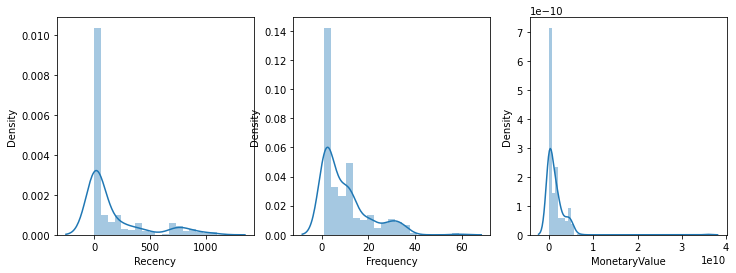

In [6]:
# Ve phan phoi de kiem tra
fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.distplot(df_customers['Recency'], ax = ax[0])
sns.distplot(df_customers['Frequency'], ax = ax[1])
sns.distplot(df_customers['MonetaryValue'], ax = ax[2])
plt.show()

# B3: phân tích skewness để lựa chọn phương pháp transform phù hợp với dữ liệu

In [7]:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_customers[x], ax=ax[0,0])
    sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_customers[x].skew().round(2))
    print(np.log(df_customers[x]).skew().round(2))
    print(np.sqrt(df_customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2))

D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

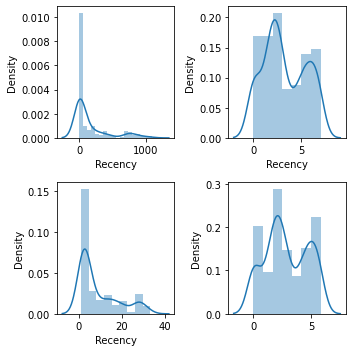

1.82
0.19
1.18
0.05


In [8]:
analyze_skewness('Recency')

D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

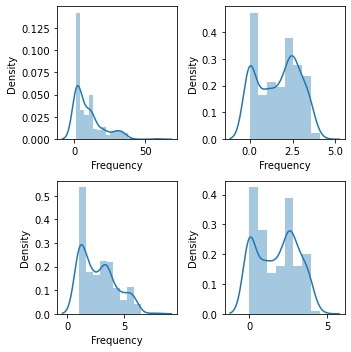

1.4
-0.09
0.6
-0.03


In [9]:
analyze_skewness('Frequency')

# Lựa chọn Transform

In [10]:
#Tiến hành transform dữ liệu
df_customers_t = pd.DataFrame()
df_customers_t['Recency'] = stats.boxcox(df_customers['Recency'])[0]
df_customers_t['Frequency'] = stats.boxcox(df_customers['Frequency'])[0]
df_customers_t['MonetaryValue'] = pd.Series(np.cbrt(df_customers['MonetaryValue'])).values
df_customers_t.head(10)

,Recency,Frequency,MonetaryValue
0,5.84,0.00,547.73
1,5.67,0.71,458.16
2,2.17,3.76,1634.10
3,1.85,3.91,1580.16
4,1.71,3.91,1903.37
5,4.45,3.24,1665.02
6,1.85,3.41,1691.70
7,1.71,3.94,1436.44
8,1.85,3.46,1704.49
9,4.12,3.30,1649.84


# B4: Scale dữ liệu

In [11]:
# Tien hanh scale du lieu
scaler = StandardScaler()
scaler.fit(df_customers_t)
df_customers_t = scaler.transform(df_customers_t)


In [12]:
pd.DataFrame(df_customers_t).head()

,0,1,2
0,1.63,-1.35,-0.60
1,1.54,-0.81,-0.77
2,-0.38,1.51,1.44
3,-0.56,1.63,1.34
4,-0.64,1.63,1.94


# B5: tìm số tâm cụm k tối ưu theo phương pháp elbow

In [13]:
# Chọn số cụm bằng Elbow
def elbow(df):
    sse = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        sse[k] = kmeans.inertia_ 

    plt.title('The Elbow Method')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

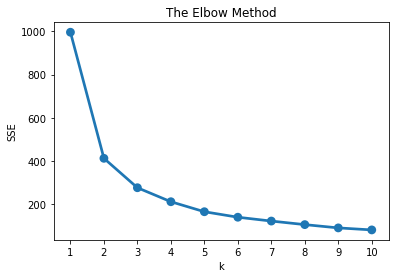

In [14]:
# sử dụng đầu vào vào df đã transform
elbow(df_customers_t)

# B6: khởi chạy thuật toán kmeans

In [15]:
# đầu vào là k số tâm cụm, df dã transform, df đã tính RFM
def get_labels(k,df_t,df):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_t)
    df['Cluster'] = model.labels_
    return df

In [16]:
df = get_labels(3,df_customers_t,df_customers)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


# B7: reset index và đổi các giá trị cụm cho phù hợp

In [17]:
df.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'MonetaryValue':'mean'
    }
).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,434.11,2.17,156843796.77
1,7.86,2.79,197947207.05
2,32.79,17.39,2757230575.57


In [18]:
df = df.reset_index()
df['Cluster'].replace({2: 'A', 1: 'B', 0 : 'C'}, inplace=True)

In [19]:
df

,Ma_KH,Recency,Frequency,MonetaryValue,Cluster
0,KH00001,1095,1,164320000.00,C
1,KH00002,858,2,96175000.00,C
2,KH00003,10,31,4363511324.00,A
3,KH00004,7,35,3945543723.00,A
4,KH00005,6,35,6895584252.00,A
...,...,...,...,...,...
327,KH00329,1,1,13204854.00,B
328,KH00330,1,1,10303904.00,B
329,KH00331,1,1,14016860.00,B
330,KH00332,1,1,10655000.00,B


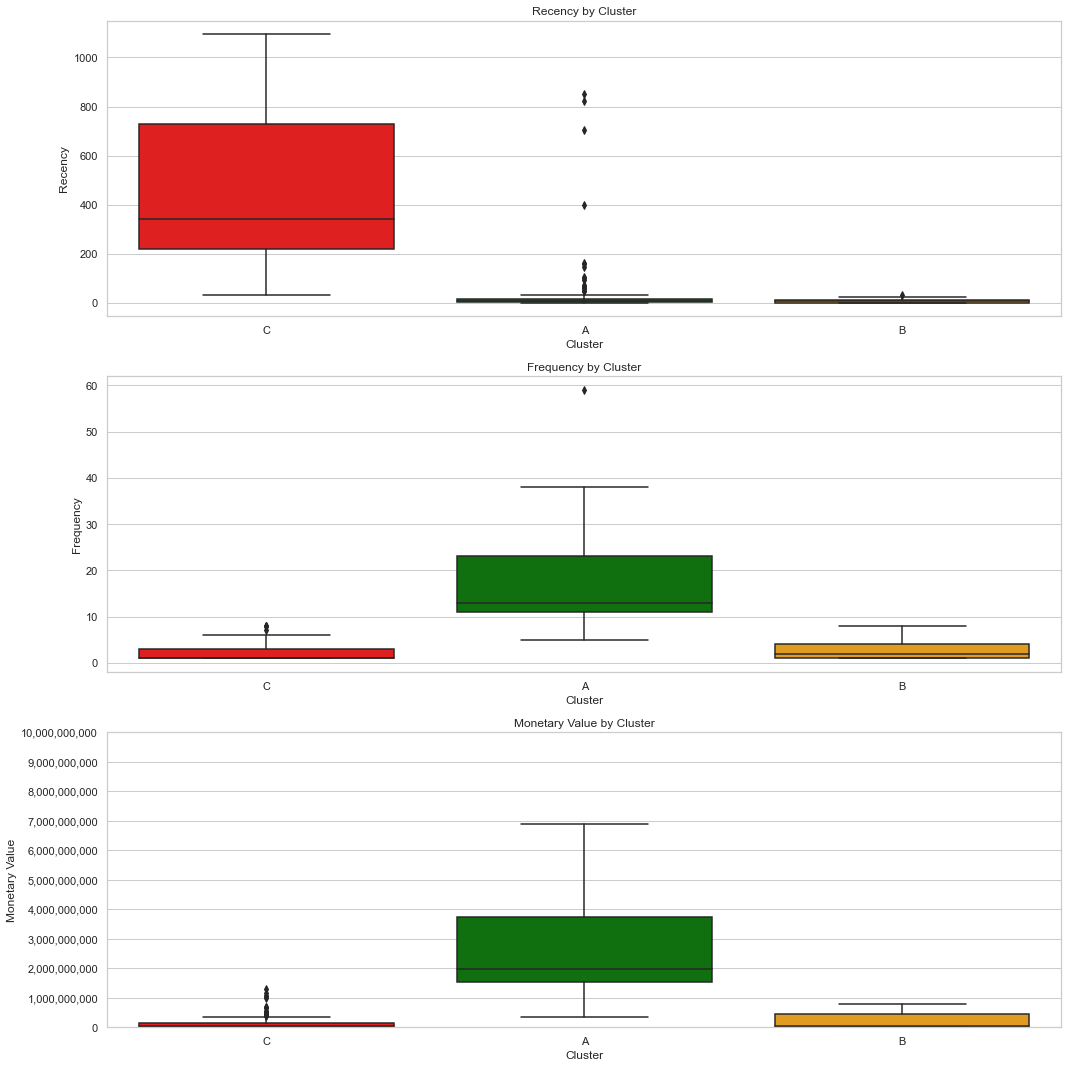

In [68]:
df['Recency'] = df['Recency'].apply(lambda x: max(x, 0))
df['Frequency'] = df['Frequency'].apply(lambda x: max(x, 0))
df['MonetaryValue'] = df['MonetaryValue'].apply(lambda x: max(x, 0))

# Định dạng tiền tệ tùy chỉnh
def currency_format(x, pos):
    return '{:,.0f}'.format(x)

# Tạo biểu đồ boxplot cho từng chỉ số Recency, Frequency, MonetaryValue theo cluster
plt.figure(figsize=(15, 15))

# Biểu đồ boxplot cho Recency
plt.subplot(3, 1, 1)
sns.boxplot(x='Cluster', y='Recency', data=df, palette={'A': 'green', 'B': 'orange', 'C': 'red'})
plt.title('Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')

# Biểu đồ boxplot cho Frequency
plt.subplot(3, 1, 2)
sns.boxplot(x='Cluster', y='Frequency', data=df, palette={'A': 'green', 'B': 'orange', 'C': 'red'})
plt.title('Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')

# Biểu đồ boxplot cho MonetaryValue
plt.subplot(3, 1, 3)
sns.boxplot(x='Cluster', y='MonetaryValue', data=df, palette={'A': 'green', 'B': 'orange', 'C': 'red'})
plt.title('Monetary Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary Value')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(currency_format))
ax.set_ylim(0, 10**10)  # Đặt giới hạn trục y từ 0 đến 10 tỷ
ax.set_yticks(range(0, 10**10 + 1, 10**9))  # Đặt các bước nhảy trên trục y mỗi 1 tỷ

plt.tight_layout()
plt.show()

# B8 ĐƯA DỮ LIỆU VÀO CSDL

In [5]:
# Kết nối với CSDL
conn = pyodbc.connect(
Trusted_Connection = "Yes",
Driver = '{ODBC Driver 17 for SQL Server}',
Server = "DESKTOP-MDDIIDJ\MSSQLSERVER01",
Database = 'Ban_Hang')
cursor = conn.cursor()

In [2]:
#Tạo bảng 
#cursor.execute("CREATE TABLE PHAN_KHUC_KH(Ma_KH varchar(20),  Recency int, Frequency int, MonetaryValue float, Phan_khuc char(1) )")

In [21]:
def Insert_PKKH(df):
    # Xóa toàn bộ dữ liệu từ bảng PHAN_KHUC_KH
    cursor.execute('''
                    DELETE FROM BAN_HANG.dbo.PHAN_KHUC_KH
                    ''')
    # Chèn dữ liệu vào bảng PHAN_KHUC_KH
    for row in df.itertuples(index=False):
        cursor.execute('''
                        INSERT INTO BAN_HANG.dbo.PHAN_KHUC_KH(Ma_KH, Recency, Frequency, MonetaryValue, Phan_khuc )
                        VALUES(?, ?, ?, ?, ?)
                        ''',
                       row[0], row[1], row[2], row[3], row[4]
                      )
    conn.commit()

In [22]:
#Insert_PKKH(df)

#  Tóm tắt các bước thực hiện

Các bước thực hiện:<br>
B1: dùng cal_RFM() để tính RFM <br>
    ex: df_customers = cal_RFM() <br>
B2: Kiểm tra phân phối của dữ liệu<br>
B3: Phân tích skewness để lựa chọn pp Transform <br>
    ex: df_customers_t['Recency'] = stats.boxcox(df_customers['Recency'])[0]<br>
B4: Scale dữ liệu để đưa vào mô hình phân cụm Kmeans<br>
    ex: scaler.fit(df_customers_t)<br>
B5: lựa chọn số tâm k tối ưu theo phương pháp elbow<br>
    ex: elbow(df_customers_t)<br>
B6: sử dụng hàm get_labels(k,df_t,df_customers) để khởi chạy thuận toán Kmeans, đầu vào là số tâm k tối ưu,dataframe đã<br> transform, và dataframe tính RFM ban đầu (ở B1)<br>
    ex: df = get_labels(3,df_customers_t,df_customers)<br>
B7: Reset index và đổi các giá trị tâm cụm<br>
B8: đưa dữ liệu vào sql bằng hàm Insert_PKKH()<br>
    ex: Insert_PKKH(df)<br>
    